In [17]:
# %install_ext https://raw.github.com/cpcloud/ipython-autotime/master/autotime.py
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 3.82 ms


In [321]:
%pylab inline
from snakebite.client import Client
import pyaml as yaml
import sys
import pythonrun
reload(pythonrun)
import os
import seaborn as sns
from sklearn import metrics
import scala_python_endive_wrapper
reload(scala_python_endive_wrapper)
from scala_python_endive_wrapper import *
import pandas as pd
import os

Populating the interactive namespace from numpy and matplotlib
time: 18.3 ms


In [4]:
hdfsclient = Client("amp-spark-master.amp", 8020, use_trash=False)
notebook_stdout = sys.stdout
notebook_stderr = sys.stderr
terminal_stdout = open('/dev/stdout', 'w')
terminal_stderr = open('/dev/stderr', 'w')
logpath = "/tmp/log"

time: 7.85 ms


In [323]:
def pr_result(y_test, y_test_pred, y_train=None, y_train_pred=None):
    fpr, tpr, thresh = metrics.precision_recall_curve(y_test, y_test_pred)
    test_auc = metrics.average_precision_score(y_test, y_test_pred)
    plot(fpr, tpr, label="test")
    plt.legend(loc=4)
    plt.figure()
    print("Test PR AUC {0}".format(test_auc))
    if (y_train != None and y_train_pred != None):
        fpr, tpr, thresh = metrics.precision_recall_curve(y_train, y_train_pred)
        train_auc = metrics.average_precision_score(y_train, y_train_pred)
        plot(fpr, tpr, label="train")
        print("Train PR AUC {0}".format(train_auc))

    
def roc_result(y_test, y_test_pred, y_train=None, y_train_pred=None):
    fpr, tpr, thresh = metrics.roc_curve(y_test, y_test_pred)
    test_auc = metrics.roc_auc_score(y_test, y_test_pred)
    plot(fpr, tpr, label="test")
    plt.legend(loc=4)
    plt.figure()
    print("Test ROC AUC {0}".format(test_auc))
    if (y_train != None and y_train_pred != None):
        fpr, tpr, thresh = metrics.precision_recall_curve(y_train, y_train_pred)
        train_auc = metrics.average_precision_score(y_train, y_train_pred)
        plot(fpr, tpr, label="train")
        print("Train PR AUC {0}".format(train_auc))



time: 26.9 ms


In [5]:

executor_mem = "200g"
cores_per_executor = 24
num_executors = 14

time: 2.75 ms


In [9]:
# CHANGE ME
dataset_creation_config = \
{
    "labels": "/user/vaishaal/endive-data/ChIPseq/labels/EGR1.train.labels.tsv", \
    "reference": "/home/eecs/akmorrow/ADAM/endive/workfiles/hg19.2bit", \
    "dnase": "/user/vaishaal/endive-data/DNASE/peaks/relaxed/", \
    "aggregatedSequenceOutput": "/user/vaishaal/endive-data/aggregated/EGR1/"
}

EGR1_PATH = "/user/vaishaal/endive-data/aggregated/EGR1/EGR1"


time: 3.97 ms


In [142]:
# this is where the magic happens
results = [] 
for seed in range(2):
        res = run_kitchensink_featurize_pipeline(EGR1_PATH,
                           "/tmp/filters.csv", 
                           logpath, 
                           seed=0,
                           filter_gen_gen=make_gaussian_filter_gen,
                           cores_per_executor=cores_per_executor,
                           sample=0.001,
                           executor_mem=executor_mem,
                           featuresOutput="/user/vaishaal/tmp/featurizedWindows/tiny/replicate-{0}/".format(seed),
                           num_executors=num_executors)
        results.append(res)
 
        
  

(256, 32)
(256, 32)
time: 5min 9s


In [174]:
res = run_solver_pipeline("/user/vaishaal/tmp/featurizedWindows/tiny/replicate-0",
                           logpath, 
                           hdfsclient,
                           executor_mem=executor_mem,
                           num_executors=num_executors,
                           valCellTypes=[8],
                           valChromosomes=["chr10"],
                           valDuringSolve=True)


/user/vaishaal/tmp/valPreds_chr11_8

time: 52.1 s


In [221]:
test_preds, df = run_test_pipeline("/user/vaishaal/tmp/featurizedWindows/tiny/replicate-1",
                                logpath, 
                                hdfsclient,
                                delete_predictions_from_hdfs=True)



time: 41.4 s


In [311]:
test_preds.shape

(207128, 2)

time: 4.71 ms


In [308]:
test_preds = test_preds[0]

time: 1.89 ms


time: 425 ms


In [319]:
def make_submission_output(outfile, test_preds, meta_df):
    meta_df = meta_df.copy(True)
    meta_df['chr_int'] = meta_df['chr'].map(lambda x: int(x.replace('chr', '').replace('X', '24').replace('Y', '25')))
    meta_df['start'] = pd.to_numeric(meta_df['start'])
    sorted_test = meta_df.sort_values(['chr_int', 'start'])[['chr', 'start', 'end']]
    prob_pred = (test_preds[:,1] - min(test_preds[:,1]))/max(test_preds[:,1] - min(test_preds[:,1]))
    sorted_test['prob'] = prob_pred
    sorted_test.to_csv(outfile, sep='\t', header=False)

time: 7.08 ms


In [320]:
make_submission_output('/tmp/out2.csv', test_preds, df)

time: 1.16 s


[False False False ..., False False False]
[ 0.16349007  0.15914384  0.14852601 ...,  0.17275107  0.32516205
  0.10261884]
Train ROC AUC 0.693530410409
Test ROC AUC 0.693530410409


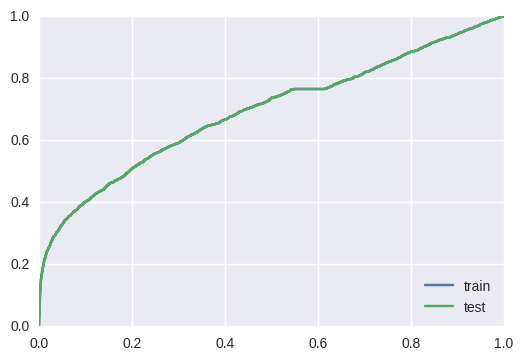

time: 463 ms


In [288]:
roc_result(test_preds[0][:,0].astype('bool'), test_preds[0][:,0].astype('bool'), prob_pred, prob_pred)

In [270]:
test_preds[0][:,1]

array([ 0.00827409,  0.0064117 ,  0.0018619 , ...,  0.01224249,
        0.07755151, -0.0178096 ])

time: 5.62 ms


#### ROC Metrics

Train PR AUC 0.0986490822579
Test PR AUC 0.0893466132806
Train ROC AUC 0.884089628045
Test ROC AUC 0.863655048408


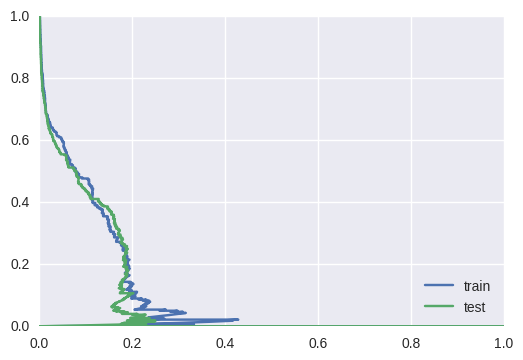

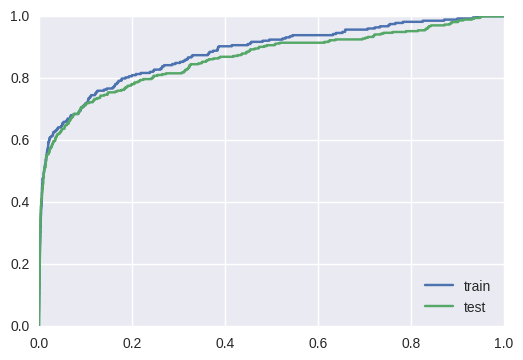

time: 912 ms


In [176]:
sys.stdout = notebook_stdout
sys.stderr = notebook_stderr
train_preds, val_preds = res
y_train = train_preds[:, 0]
y_train_pred = train_preds[:, 1]

y_test_full = test_preds[:, 0]
y_test_pred_full = test_preds[:, 1]
y_test = y_test_full[np.where(y_test_full >= 0)]
y_test_pred = y_test_pred_full[np.where(y_test_full >= 0)]


pr_result(y_train, y_test, y_train_pred, y_test_pred)
roc_result(y_train, y_test, y_train_pred, y_test_pred)